In [ ]:
! pip install -r ../requirements.txt

In [1]:
import os
import numpy as np
import pandas as pd
import nltk, re
import time
import string
import seaborn as sns

from os import path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download('omw-1.4')

%matplotlib inline
import matplotlib.pyplot as plt

!pip install tensorflow_addons
import tensorflow_addons as tfa

# Keras specific
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import LearningRateScheduler

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


2023-01-19 22:00:28.790216: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Reading data

#### __Training data:__

In [142]:
train_df = pd.read_csv('../data/train_complete.csv', encoding='utf-8', header=0)
train_df.head()
print(train_df.shape)

(47615, 2)


#### __Test data:__

In [143]:
lines = []
with open('../data/test_text.txt') as f:
    lines = [line.rstrip('\n') for line in f]
print(len(lines))
test_df = pd.DataFrame (lines, columns = ['tweet'])
print(test_df.shape)

org_test_df = pd.DataFrame(columns=["tweet"]) # Used later to prepare the result csv file
org_test_df["tweet"] = test_df["tweet"].tolist()

12284
(12284, 1)


## 2. Train a Logistic Regression Model
### We have used a logistic regression model after testing a decision tree classifier, a gradient boosting classifier, a random forest classifier and an MLP classifier. A Keras model also was implemented but the f1 score generated by logistic regression was the highest. Added to this, logistic regression is interpretable, quick to train and easy to implement. 
Here, we apply pre-processing and vectorization operations and train the model. 

### 2.1 Split Training data into training and validation and process text field

In [144]:
classes = train_df['label'].unique()
classes.sort()
print(classes)
class_id_distribution = train_df['label'].value_counts()
print(class_id_distribution)

[0 1 2]
1    21542
2    18668
0     7405
Name: label, dtype: int64


In [145]:
train_df.isna().sum() # Finding the number of null entries

tweet    0
label    0
dtype: int64

In [146]:
print("Splitting data into training and validation...")
X_train, X_val, y_train, y_val = train_test_split(
    train_df[["tweet"]],
    train_df["label"].values,
    test_size=0.10,
    shuffle=True,
    random_state=324,
)

# X_train, X_val2, y_train, y_val2 = train_test_split(
#     train_df[["tweet"]],
#     train_df["label"].values,
#     test_size=0.0001,
#     shuffle=True,
#     random_state=324,
# )

Splitting data into training and validation...


In [147]:
print(X_train.shape)
print(X_val.shape)

(42853, 1)
(4762, 1)


In [94]:
#Making the samples equal (almost) for each class (not used but can be used if class weights are not given)
X_train_sample_class_0 = X_train[y_train == 0]
X_train_sample_class_1 = X_train[y_train == 1]
X_train_sample_class_2 = X_train[y_train == 2]

X_train_sample_class_1 = resample(X_train_sample_class_1,
             replace=False,
             n_samples=X_train_sample_class_0.shape[0],
             random_state=42)
X_train_sample_class_2 = resample(X_train_sample_class_2,
             replace=False,
             n_samples=X_train_sample_class_0.shape[0],
             random_state=42)

y_train_sample_class_0 = np.zeros(X_train_sample_class_0.shape[0])
y_train_sample_class_1 = np.ones(X_train_sample_class_1.shape[0])
y_train_sample_class_2 = np.repeat(2, X_train_sample_class_2.shape[0])

X_train = pd.concat([pd.concat([X_train_sample_class_0, X_train_sample_class_1]), X_train_sample_class_2])
y_train = np.concatenate((np.concatenate((y_train_sample_class_0, y_train_sample_class_1), axis=0), y_train_sample_class_2), axis=0)

print(X_train.shape)
print(y_train.shape)

(22212, 1)
(22212,)


In [148]:
# Stop words removal and stemming
# Let's get a list of stop words from the NLTK library
stop = stopwords.words("english")
stop_words = [word for word in stop]

snow = SnowballStemmer("english")

def process_text(texts):
    final_text_list = []
    for sent in texts:

        filtered_sentence = []
        
        # convert to lowercase
        sent = sent.lower()
        # Remove leading/trailing whitespace
        sent = sent.strip()
        # Remove extra space and tabs
        sent = re.sub("\s+", " ", sent)
        # Remove retweets, links, hashtags
        sent = re.sub('@[^\s]+','',sent) 
        sent = re.sub('http[^\s]+','',sent)
        sent = re.sub('#[^\s]+','',sent)
        # Remove numerics
        sent = ''.join([i for i in sent if not i.isdigit()])
        # Remove emojis
        emojis = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002500-\U00002BEF"  # chinese char
            u"\U00002702-\U000027B0"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642" 
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"  # dingbats
            u"\u3030""]+", re.UNICODE)
        sent = re.sub(emojis, '', sent)
        # Remove some unicode characters
        sent = sent.replace('\u2019', '')
        sent = sent.replace('\u002c', '')
        
        # Tokenize the sentence
        words = word_tokenize(sent)
        
        #STEMMING
        for i in range(len(words)):
            # Check if its length>2
            if len(words[i])>2:
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(words[i]))
#                 filtered_sentence.append(words[i])
    
        final_string = " ".join(filtered_sentence)  # final string of cleaned words

        final_text_list.append(final_string)

    return final_text_list

print("Processing the text fields...")

X_train["tweet"] = process_text(X_train["tweet"].tolist())
X_val["tweet"] = process_text(X_val["tweet"].tolist())
test_df["tweet"] = process_text(test_df["tweet"].tolist())
print(X_train.shape)
print(X_val.shape)

# Remove punctuations
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

X_train["tweet"] = X_train["tweet"].apply(lambda x: cleaning_punctuations(x))
X_val["tweet"] = X_val["tweet"].apply(lambda x: cleaning_punctuations(x))
test_df["tweet"] = test_df["tweet"].apply(lambda x: cleaning_punctuations(x))

Processing the text fields...
(42853, 1)
(4762, 1)


In [149]:
# Use TD-IDF to vectorize to vectors of len 5000.
tf_idf_vectorizer = TfidfVectorizer(max_features=18000)

# Fit the vectorizer to training data
tf_idf_vectorizer.fit(X_train["tweet"].values)

print("Transforming the text fields (Bag of Words)...")
# Transform text fields
X_train = tf_idf_vectorizer.transform(X_train["tweet"].values).toarray()
X_val = tf_idf_vectorizer.transform(X_val["tweet"].values).toarray()
test_df = tf_idf_vectorizer.transform(test_df["tweet"].values).toarray()

print("Shapes of features: Training and Validation and Test")
print(X_train.shape, X_val.shape, test_df.shape)

Transforming the text fields (Bag of Words)...
Shapes of features: Training and Validation and Test
(42853, 18000) (4762, 18000) (12284, 18000)


### APPROACH - 1. Use the pipeline approach with logistic regression for classification

In [150]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
##########################

train_data = pd.DataFrame(X_train)
val_data = pd.DataFrame(X_val)
# Selecting numerical features (this pipeline would work with categorical or text features too with slight modifications)
numerical_features = train_data.select_dtypes(include=np.number).columns.values.tolist()

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) 
                                ])                            

# Combine all data preprocessors from above
data_processor = ColumnTransformer([
    ('numerical_processing', numerical_processor, numerical_features)
])

# Visualize the data processing pipeline
from sklearn import set_config
set_config(display='diagram')
data_processor


ColumnTransformer(transformers=[('numerical_processing',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  MinMaxScaler())]),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...])])

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline created with all data processors, along with an estimator at the end (tried different ones but settled on logistic regression)

pipeline = Pipeline([
#     ('data_processing', data_processor),
#     ('dt', DecisionTreeClassifier()),
#     ('mlp', MLPClassifier(alpha=0.005, verbose=True, learning_rate_init=0.001, learning_rate='adaptive', early_stopping=True, max_iter=100, hidden_layer_sizes=(50,50,50))),
#     ('rf', RandomForestClassifier(max_depth=35, n_estimators=400))
    ('lg', LogisticRegression(solver='newton-cg', penalty='l2', C=4.2, random_state=1, class_weight={0:0.4, 1:0.186, 2:0.215})),
#     ('gbc', HistGradientBoostingClassifier(l2_regularization=0.0001, scoring='f1_macro', verbose=1, learning_rate=0.1, tol=1e-04))
                    ])

# Visualize the pipeline
from sklearn import set_config
set_config(display='diagram')
pipeline


Pipeline(steps=[('lg',
                 LogisticRegression(C=4.2,
                                    class_weight={0: 0.4, 1: 0.186, 2: 0.215},
                                    random_state=1, solver='newton-cg'))])

In [ ]:
# Fit the classifier to the train data
pipeline.fit(X_train, y_train)


In [ ]:
# Use the fitted model to make predictions on the train dataset
train_predictions = pipeline.predict(X_train)
print(train_predictions)

print('Model performance on the train set:')
confusion_matrix = metrics.confusion_matrix(y_train, train_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_train, train_predictions))
print("Train f1 score:", f1_score(y_train, train_predictions, average='macro'))

In [ ]:
# Use the fitted model to make predictions on the validation dataset
val_predictions = pipeline.predict(X_val)

print('Model performance on the validation set:')
confusion_matrix = metrics.confusion_matrix(y_val, val_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_val, val_predictions))
print("Validation f1 score:", f1_score(y_val, val_predictions, average='macro'))

In [21]:
# Hyperparameter Tuning for reducing generalization gap
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randInt

### HYPERPARAMETER SEARCH ###
########################################

# Parameter grid for GridSearch (some combinations were already eliminated)
# More combinations can be tried with more time using RandomizedSearchCV
param_grid = {"lg__C" : [0.5, 0.8, 1, 1.3],
              "lg__solver": ['liblinear', 'newton-cg'],
              "lg__class_weight": [None, 'balanced']
                }

grid_search = GridSearchCV(pipeline, # Base model
                           param_grid, # Parameters to try
                           cv = 3, # Apply 3-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = None, # Use all available processors
                           scoring='f1_macro'
                          )

In [22]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('data_processing',
                                        ColumnTransformer(transformers=[('numerical_processing',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          MinMaxScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22,
                                                                          23,
                                                                          24,
                                                                          25,
                                                                          26,
                                                                          27,
                                                                          28,
                                                                          29, ...])])),
                                       ('lg',
                                        LogisticRegression(C=0.5,
                                                           solver='newton-cg'))]),
             param_grid={'lg__C': [0.5, 0.8, 1, 1.3],
                         'lg__class_weight': [None, 'balanced'],
                         'lg__solver': ['liblinear', 'newton-cg']},
             scoring='f1_macro', verbose=1)

In [23]:
# Print the optimal hyperparameters and the corresponding best validation metric
print(grid_search.best_params_)
print(grid_search.best_score_)

{'lg__C': 0.5, 'lg__class_weight': 'balanced', 'lg__solver': 'liblinear'}
0.6286222113343231


In [24]:
# Get the best model out of GridSearchCV
classifier = grid_search.best_estimator_

# Fit the best model to the train data once more
classifier.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('lg',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    solver='liblinear'))])

Model performance on the validation set:
              precision    recall  f1-score   support

           0       0.46      0.67      0.54       730
           1       0.69      0.60      0.65      2211
           2       0.69      0.67      0.68      1821

    accuracy                           0.64      4762
   macro avg       0.61      0.65      0.62      4762
weighted avg       0.66      0.64      0.64      4762

Validation f1 score: 0.623775275021862


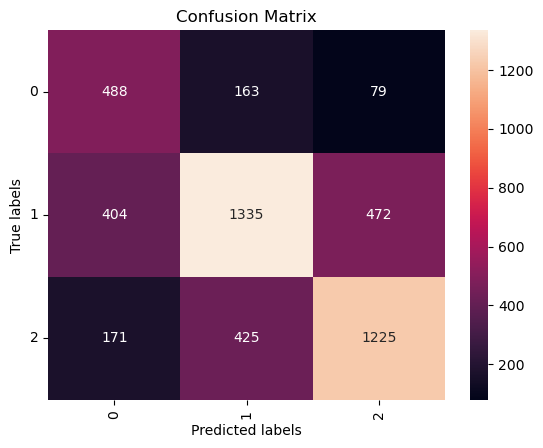

In [25]:
# Use the fitted model to make predictions on the validation dataset
val_predictions = classifier.predict(X_val)

print('Model performance on the validation set:')
confusion_matrix = metrics.confusion_matrix(y_val, val_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_val, val_predictions))
print("Validation f1 score:", f1_score(y_val, val_predictions, average='macro'))

### Approach 2. Use a keras model implementation for classification (POC)

In [11]:
# Storing the original labels (will be converted to categorical)
y_train_org = y_train
y_val_org = y_val

In [12]:
y_train = y_train_org
y_val = y_val_org

In [13]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(42853, 7000)
(4762, 7000)
(42853,)
(4762,)


In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)

(42853, 3)


In [20]:
model = Sequential()
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.01), activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(100, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [21]:
# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00025)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=tfa.metrics.F1Score(num_classes=3, average='macro'))
#              )

In [22]:
import math
def step_decay(epoch):
    initial_lrate = 0.0005
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                70010     
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 100)               1100      
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

In [24]:
# Early stopping and adaptive learning rate could be implemented here
# Hyperparameter search could also be done here on regularization constant, optimizer and batch size
history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_val, y_val), callbacks=callbacks_list,)

Epoch 1/60
670/670 [==============================] - 3s 4ms/step - loss: 1.0615 - f1_score: 0.2847 - val_loss: 0.9637 - val_f1_score: 0.4111 - lr: 5.0000e-04
Epoch 2/60
670/670 [==============================] - 2s 3ms/step - loss: 0.9602 - f1_score: 0.4148 - val_loss: 0.9092 - val_f1_score: 0.4463 - lr: 5.0000e-04
Epoch 3/60
670/670 [==============================] - 2s 3ms/step - loss: 0.9315 - f1_score: 0.4321 - val_loss: 0.8914 - val_f1_score: 0.4486 - lr: 5.0000e-04
Epoch 4/60
670/670 [==============================] - 2s 3ms/step - loss: 0.9174 - f1_score: 0.4404 - val_loss: 0.8874 - val_f1_score: 0.4458 - lr: 5.0000e-04
Epoch 5/60
670/670 [==============================] - 2s 3ms/step - loss: 0.9106 - f1_score: 0.4717 - val_loss: 0.8836 - val_f1_score: 0.4543 - lr: 5.0000e-04
Epoch 6/60
670/670 [==============================] - 2s 3ms/step - loss: 0.9060 - f1_score: 0.5058 - val_loss: 0.8801 - val_f1_score: 0.5023 - lr: 5.0000e-04
Epoch 7/60
670/670 [==========================

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1 scores')
plt.ylabel('f1_Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

298/298 [==============================] - 0s 1ms/step
[2 1 0 ... 2 1 1]
Model performance on the validation set:
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      1468
           1       0.63      0.71      0.66      4363
           2       0.69      0.63      0.66      3692

    accuracy                           0.64      9523
   macro avg       0.61      0.59      0.60      9523
weighted avg       0.64      0.64      0.63      9523

Validation f1 score: 0.5981224457489266


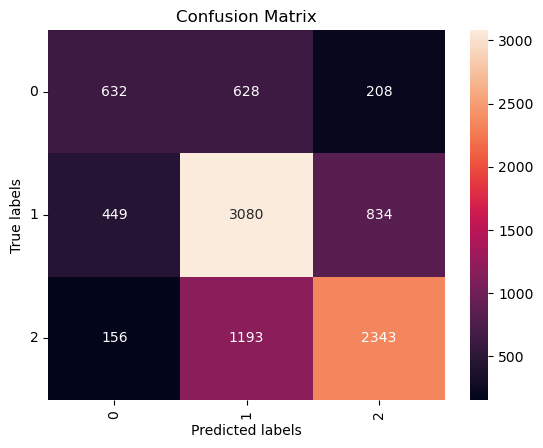

In [186]:
# Use the fitted model to make predictions on the validation dataset
val_predictions = model.predict(X_val)
val_predictions = np.argmax(val_predictions, axis=-1)
print(val_predictions)

print('Model performance on the validation set:')
confusion_matrix = metrics.confusion_matrix(y_val_org, val_predictions)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0)

print(classification_report(y_val_org, val_predictions))
print("Validation f1 score:", f1_score(y_val_org, val_predictions, average='macro'))

### Best performance obtained by logistic regression model

In [140]:
print(test_df.shape)

test_predictions = pipeline.predict(test_df)
# test_predictions = np.argmax(test_predictions, axis=-1) # Used if keras model is used

(12284, 10000)


In [141]:
import pandas as pd

result_df = pd.DataFrame(columns=["tweet", "label"])
result_df["tweet"] = org_test_df["tweet"].tolist()
result_df["label"] = test_predictions

result_df.to_csv("../result.csv", index=False)

# print(len(result_df["tweet"]))
# print(len(result_df["label"]))

# with open('../result.csv','w') as file:
#     file.write("tweet,label")
#     file.write('\n')
#     for i in range(len(result_df["tweet"])):
#         file.write("\"" +result_df["tweet"][i])
#         file.write('\n')
#         file.write("\"" + ",")
#         file.write(str(int(result_df["label"][i])))
#         file.write('\n')